# Disseration Experiment 4c
# Generate LIME and IDENTITY Metric October Seven¶
Ciaran Finnegan October 2023

In [1]:
# Import libs
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
import shap
import random

from IPython.display import display, HTML

# Import necessary libraries for LIME calculations
import lime
import lime.lime_tabular

# Libraries required for metrics calculations
from scipy.spatial import distance
from sklearn.cluster import KMeans

from sklearn.preprocessing import LabelEncoder
import warnings
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample


# Classifier training (not used for explainability)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Data Visualisation and Exploration

## Import Data

In [2]:
ds_file_to_load = 'credit_default_data.csv'
df = pd.read_csv(ds_file_to_load)

## Data Exploration

In [3]:
def styled_dataframe(df):
    styles = {
        'selector': 'table',
        'props': [('background-color', '#f4f4f4'),
                  ('color', '#000000'),
                  ('border-color', '#e0e0e0'),
                  ('border', '1px solid #e0e0e0'),
                  ('font-family', 'Arial, sans-serif'),
                  ('width', '100%')]
    }
    
    # Apply the styles to the dataframe
    styled_df = (df.style.set_table_styles([styles])
                 .set_properties(subset=df.columns, **{'min-width': '5000px', 'text-align': 'center'})
                 .format(None, na_rep='NA'))
    
    # Convert styled dataframe to HTML and wrap in a div container for scrolling
    styled_html = f'<div style="width:100%; overflow-x:auto;">{styled_df.render()}</div>'
    
    return display(HTML(styled_html))

# To check the function (using a sample dataframe)
sample_df = pd.DataFrame({
    'A': [1, 2, 3, 4, 5],
    'B': [5, 6, 7, 8, 9],
    'C': [1, 2, 3, 4, 5],
    'D': [5, 6, 7, 8, 9],
    'E': [1, 2, 3, 4, 5]
})
styled_dataframe(sample_df)


this method is deprecated in favour of `Styler.to_html()`


### Dataset Structure

In [4]:
# Display the first few rows of the dataset to understand its structure
#df.head()
#print(df.head().to_string())
styled_dataframe(df.head())

this method is deprecated in favour of `Styler.to_html()`


In [5]:
# Reset default Pandas display options
pd.reset_option('display.max_columns')
pd.reset_option('display.expand_frame_repr')
pd.reset_option('display.max_colwidth')
# Display the dataframe
display(df.head())

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0     -2  ...          0          0          0         0       689         0   
1      0  ...       3272       3455       3261         0      1000      1000   
2      0  ...      14331      14948      15549      1518      1500      1000   
3      0  ...      28314      28959      29547      2000      2019      1200   
4      0  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default  
0         0         0         0        1  
1      1000         0      2000        1  
2      1000      1000      5000        0  
3      1100      1069      1000        0  
4      9000       689       679        0  

[5 rows x 24 columns]

In [6]:
# Display the dataframe as plain text to bypass any CSS/HTML styles
print(df.head().to_string())

   LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default
0      20000    2          2         1   24      2      2     -1     -1     -2     -2       3913       3102        689          0          0          0         0       689         0         0         0         0        1
1     120000    2          2         2   26     -1      2      0      0      0      2       2682       1725       2682       3272       3455       3261         0      1000      1000      1000         0      2000        1
2      90000    2          2         2   34      0      0      0      0      0      0      29239      14027      13559      14331      14948      15549      1518      1500      1000      1000      1000      5000        0
3      50000    2          2         1   37      0      0      0      0      0      0      46990      48233      492

### Generate Visualizations

In [7]:
# Set up the target and features to be visualised

sTarget_feature = 'default'
sFeature_analysis_1 = 'LIMIT_BAL'
sFeature_analysis_2 = 'AGE'
sFeature_analysis_3 = 'SEX'
sFeature3_ticklabel1 = 'Male'
sFeature3_ticklabel2 = 'Female'

In [8]:
# Generate Visualizations to better understand the data distribution and relationships between features.

#### Bar and Box Plot Visualisations

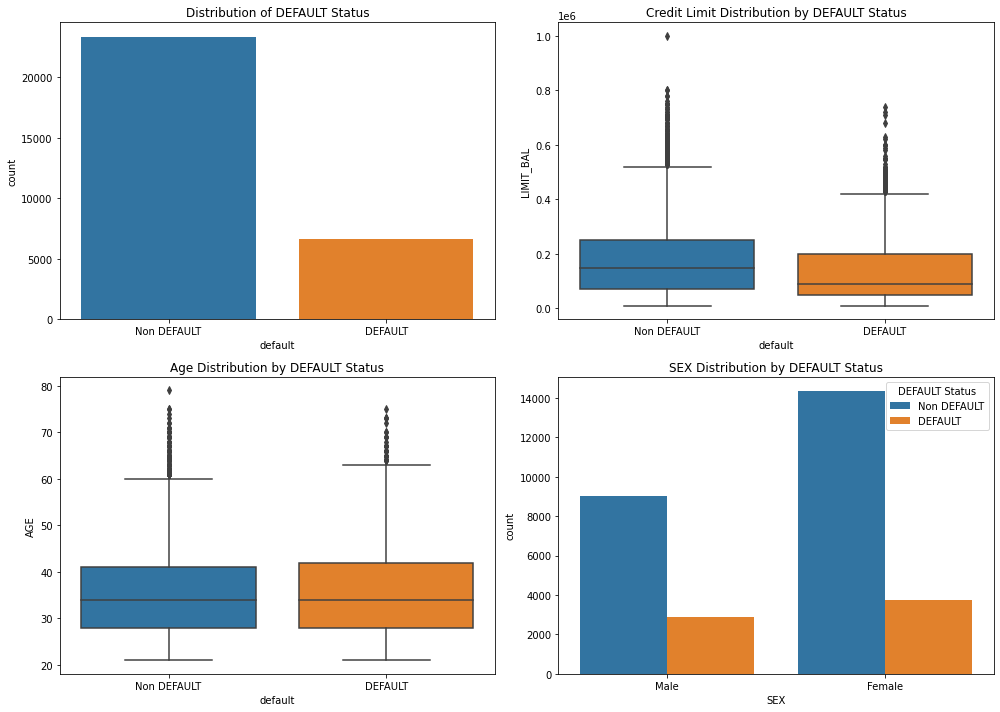

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure and axes
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Plot distribution of the dataset target variable
sns.countplot(data=df, x=sTarget_feature, ax=ax[0, 0])
sPlot_title1 = 'Distribution of ' + sTarget_feature.upper() + ' Status'
ax[0, 0].set_title(sPlot_title1)
ax[0, 0].set_xticklabels(['Non ' + sTarget_feature.upper(), sTarget_feature.upper()])

# Plot distribution of <feature one> based on target variable status
sns.boxplot(data=df, x=sTarget_feature, y=sFeature_analysis_1, ax=ax[0, 1])
sPlot_title2 = 'Credit Limit Distribution by ' + sTarget_feature.upper() + ' Status'
ax[0, 1].set_title(sPlot_title2)
ax[0, 1].set_xticklabels(['Non ' + sTarget_feature.upper(), sTarget_feature.upper()])

# Plot distribution of <feature two>  based on target variable status
sns.boxplot(data=df, x=sTarget_feature, y=sFeature_analysis_2, ax=ax[1, 0])
sPlot_title3 = 'Age Distribution by ' + sTarget_feature.upper() + ' Status'
ax[1, 0].set_title(sPlot_title3)
ax[1, 0].set_xticklabels(['Non ' + sTarget_feature.upper(), sTarget_feature.upper()])

# Plot distribution of <feature three> based on target variable status
sns.countplot(data=df, x=sFeature_analysis_3, hue=sTarget_feature, ax=ax[1, 1])
sPlot_title4 = sFeature_analysis_3.upper() + ' Distribution by ' + sTarget_feature.upper() + ' Status'
ax[1, 1].set_title(sPlot_title4)
ax[1, 1].set_xticklabels([sFeature3_ticklabel1, sFeature3_ticklabel2])
ax[1, 1].legend(title=sTarget_feature.upper() + ' Status', labels=['Non ' + sTarget_feature.upper(), sTarget_feature.upper()])

plt.tight_layout()
plt.show()


#### Heatmap Visualisation

In [10]:
# Would need feature reduction to work effectively - or some other filtering

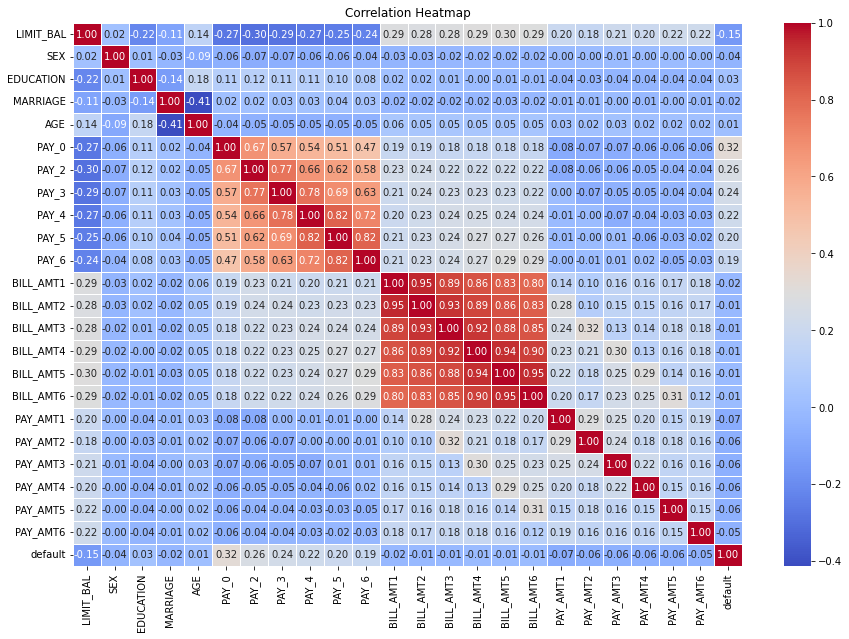

In [11]:
# Plotting correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

#### Distributions

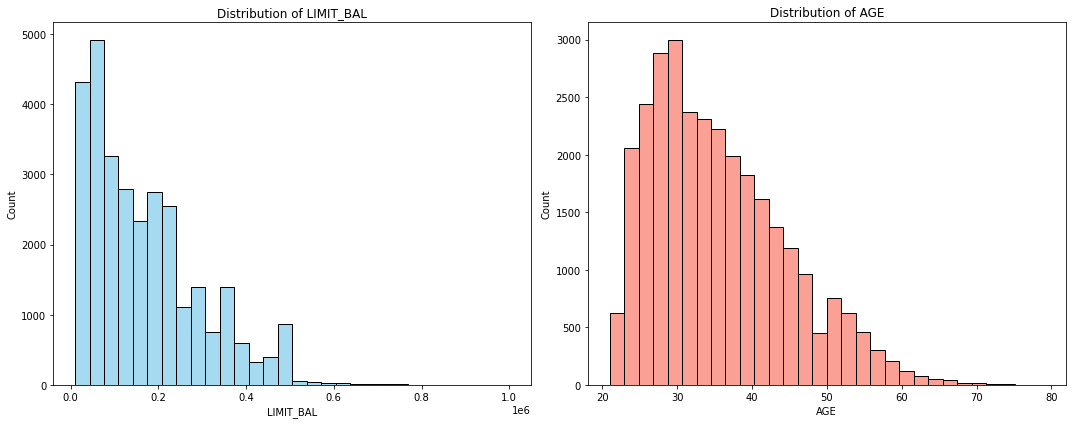

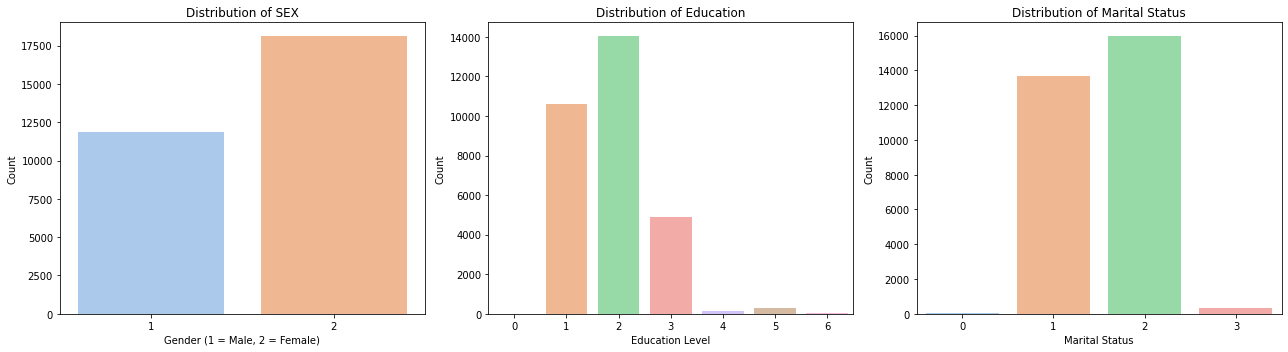

In [12]:
# Plotting distributions for continuous features
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(df[sFeature_analysis_1], bins=30, ax=ax[0], color="skyblue")
ax[0].set_title("Distribution of "+sFeature_analysis_1.upper())
ax[0].set_xlabel(sFeature_analysis_1.upper())
#ax[0].set_xlabel("Credit Limit")
ax[0].set_ylabel("Count")

sns.histplot(df[sFeature_analysis_2], bins=30, ax=ax[1], color="salmon")
ax[1].set_title("Distribution of "+ sFeature_analysis_2.upper())
ax[1].set_xlabel(sFeature_analysis_2.upper())
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# Plotting distributions for categorical features
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(data=df, x=sFeature_analysis_3, ax=ax[0], palette="pastel")
ax[0].set_title("Distribution of " + sFeature_analysis_3.upper())
ax[0].set_xlabel("Gender (1 = Male, 2 = Female)")
ax[0].set_ylabel("Count")

sns.countplot(data=df, x="EDUCATION", ax=ax[1], palette="pastel")
ax[1].set_title("Distribution of Education")
ax[1].set_xlabel("Education Level")
ax[1].set_ylabel("Count")

sns.countplot(data=df, x="MARRIAGE", ax=ax[2], palette="pastel")
ax[2].set_title("Distribution of Marital Status")
ax[2].set_xlabel("Marital Status")
ax[2].set_ylabel("Count")

plt.tight_layout()
plt.show()


# Feature Engineering

## Check for Missing Data

In [13]:
# Determine the threshold for missing values
threshold = 0.75 * len(df)

# Identify columns with missing values greater than the threshold
missing_columns = df.columns[df.isnull().sum() > threshold]

# Print the columns with more than 75% missing values
print("Columns with more than 75% missing values:", missing_columns)

# Drop columns with missing values greater than the threshold
df = df.drop(columns=missing_columns)

# Save or continue processing with columns removed that had high volumes of missing data


Columns with more than 75% missing values: Index([], dtype='object')


In [14]:
# Display the first few rows of the dataset to re-check structure once any columns with 
# significant amounts of missing data have been removed
df.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0     -2  ...          0          0          0         0       689         0   
1      0  ...       3272       3455       3261         0      1000      1000   
2      0  ...      14331      14948      15549      1518      1500      1000   
3      0  ...      28314      28959      29547      2000      2019      1200   
4      0  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default  
0         0         0         0        1  
1      1000         0      2000        1  
2      1000      1000      5000        0  
3      1100      1069      1000        0  
4      9000       689       679        0  

[5 rows x 24 columns]

## Categorical Data 

In [15]:
# List of categorical columns
cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [16]:
# Adjust cat columns to range from 0
# df[cat_cols] = df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform)

In [17]:
# One-hot encode categorical variables
#df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df_encoded = pd.get_dummies(df, columns=cat_cols)

In [18]:
df.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0     -2  ...          0          0          0         0       689         0   
1      0  ...       3272       3455       3261         0      1000      1000   
2      0  ...      14331      14948      15549      1518      1500      1000   
3      0  ...      28314      28959      29547      2000      2019      1200   
4      0  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default  
0         0         0         0        1  
1      1000         0      2000        1  
2      1000      1000      5000        0  
3      1100      1069      1000        0  
4      9000       689       679        0  

[5 rows x 24 columns]

In [19]:
# Display the first few rows of the dataset to understand its structure
df_encoded.head()

LIMIT_BAL  AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0      20000   24       3913       3102        689          0          0   
1     120000   26       2682       1725       2682       3272       3455   
2      90000   34      29239      14027      13559      14331      14948   
3      50000   37      46990      48233      49291      28314      28959   
4      50000   57       8617       5670      35835      20940      19146   

   BILL_AMT6  PAY_AMT1  PAY_AMT2  ...  PAY_6_-2  PAY_6_-1  PAY_6_0  PAY_6_2  \
0          0         0       689  ...         1         0        0        0   
1       3261         0      1000  ...         0         0        0        1   
2      15549      1518      1500  ...         0         0        1        0   
3      29547      2000      2019  ...         0         0        1        0   
4      19131      2000     36681  ...         0         0        1        0   

   PAY_6_3  PAY_6_4  PAY_6_5  PAY_6_6  PAY_6_7  PAY_6_8  
0        0        0        0        0        0        0  
1        0        0        0        0        0        0  
2        0        0        0        0        0        0  
3        0        0        0        0        0        0  
4        0        0        0        0        0        0  

[5 rows x 92 columns]

In [20]:
# display all columns
pd.set_option('display.max_columns', None)
print(df_encoded)

       LIMIT_BAL  AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0          20000   24       3913       3102        689          0          0   
1         120000   26       2682       1725       2682       3272       3455   
2          90000   34      29239      14027      13559      14331      14948   
3          50000   37      46990      48233      49291      28314      28959   
4          50000   57       8617       5670      35835      20940      19146   
...          ...  ...        ...        ...        ...        ...        ...   
29995     220000   39     188948     192815     208365      88004      31237   
29996     150000   43       1683       1828       3502       8979       5190   
29997      30000   37       3565       3356       2758      20878      20582   
29998      80000   41      -1645      78379      76304      52774      11855   
29999      50000   46      47929      48905      49764      36535      32428   

       BILL_AMT6  PAY_AMT1  PAY_AMT2  P

# Build Model

## Split Features + Target

In [21]:
# Split data into features and target
X = df_encoded.drop('default', axis=1)
y = df_encoded['default']

## Split Data into Test/Training Datasets

In [22]:
# Split into inference and training splits
X_train, X_inf, y_train, y_inf = train_test_split(X, y, test_size=0.30, random_state=42)

In [23]:
# Split Train into train test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.30, random_state=42)

In [24]:
X_train = X_train.reset_index(drop=True)
X_test= X_test.reset_index(drop=True)
X_inf = X_inf.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test= y_test.reset_index(drop=True)
y_inf = y_inf.reset_index(drop=True)

### Basic Additional Data Exploration (Training Data)

In [25]:
# Train model Stats

print("Number of Features:", X_train.shape[1])
print("Number Continuous Features:", X_train.shape[1] - len(cat_cols))
print("Number Categorical Features:", len(cat_cols))
print("Number Train Examples:", X_train.shape[0])
print("Number Positive Train Examples:", (y_train == 1).sum())
print("Number Negative Train Examples:", (y_train == 0).sum())

Number of Features: 91
Number Continuous Features: 82
Number Categorical Features: 9
Number Train Examples: 14700
Number Positive Train Examples: 3292
Number Negative Train Examples: 11408


## Downsample Majority Class

In [26]:
# Separate the majority and minority classes in the training data
X_train_majority = X_train[y_train == 0]
X_train_minority = X_train[y_train == 1]
y_train_majority = y_train[y_train == 0]
y_train_minority = y_train[y_train == 1]

# Under-sample the majority class
X_train_majority_downsampled, y_train_majority_downsampled = resample(
    X_train_majority, 
    y_train_majority,
    replace=False, 
    n_samples=len(y_train_minority), 
    random_state=42
)

# Combine the down-sampled majority class with the minority class
X_train_downsampled = pd.concat([X_train_majority_downsampled, X_train_minority])
y_train_downsampled = pd.concat([y_train_majority_downsampled, y_train_minority])

## Apply RF Hyperparameters

In [27]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2,
                           scoring='recall_macro')

grid_search.fit(X_train_downsampled, y_train_downsampled)

# Get the best parameters
best_params = grid_search.best_params_

print(best_params)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


## Train Model

In [28]:
# Set Up Random Forest model
# Train the Random Forest classifier with the best parameters
rf_classifier = RandomForestClassifier(**best_params, random_state=42)
#rf_classifier = RandomForestClassifier(random_state=42)
#rf_classifier.fit(X_train, y_train)

In [29]:
# Set up LGBMClassifier model
lgbm_model = lgb.LGBMClassifier()

In [30]:
# Assign model
model = rf_classifier 
#model = lgbm_model 

In [31]:
# Train chosen model
#model.fit(X_train, y_train)
# Retrain the Random Forest classifier on the downsampled data
model.fit(X_train_downsampled, y_train_downsampled)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, n_estimators=50,
                       random_state=42)

# Evaluate Model

## Predict on Test Data

In [32]:
# Predict on the test data
y_pred = model.predict(X_test)

## Assess Model Peformance

In [33]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

#accuracy, classification_rep, conf_matrix

In [34]:
# Extract metrics directly from the classification_report function in a structured format
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Organize the metrics into a dataframe
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'ROC AUC Score', 'Precision (Class 0)', 'Recall (Class 0)', 'F1-Score (Class 0)', 
               'Precision (Class 1)', 'Recall (Class 1)', 'F1-Score (Class 1)'],
    'Value': [accuracy, roc_auc, 
              report_dict['0']['precision'], report_dict['0']['recall'], report_dict['0']['f1-score'],
              report_dict['1']['precision'], report_dict['1']['recall'], report_dict['1']['f1-score']]
})

# Display the dataframe in a tabular format
display(HTML(metrics_df.to_html(index=False, classes="table table-striped table-bordered")))


# Generate LIME Values

#### First Breakout

In [35]:
# Create a LIME explainer object
# The training data is required to compute mean and covariance statistics that are used for data perturbation.
# mode="classification" indicates we're working on a classification problem.
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_downsampled.values, 
                                                   feature_names=X_train_downsampled.columns.tolist(), 
                                                   class_names=['Not Default', 'Default'], 
                                                   mode='classification')

In [36]:
# Function to explain and display LIME values for a specific instance
def explain_instance1(instance):
    """
    Generate LIME explanation for a specific instance.
    
    Parameters:
    - instance (numpy array): The instance for which the LIME explanation is to be generated.
    
    Returns:
    - exp (Lime explanation object): The LIME explanation for the instance.
    """
    # Get the prediction for the instance
    prediction = model.predict_proba(instance.reshape(1, -1))
    
    # Generate LIME explanation for the instance
    exp = explainer.explain_instance(instance, model.predict_proba, num_features=len(X_train_downsampled.columns))
    
    # Display the LIME explanation
    print(f'Instance Predicted Probability (Default): {prediction[0][1]:.2f}')
    exp.show_in_notebook(show_table=True)
    
    return exp

In [37]:
# Generate LIME explanations for the first 10 instances in the test dataset
for i in range(3):
    explain_instance1(X_test.iloc[i].values)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Instance Predicted Probability (Default): 0.30


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Instance Predicted Probability (Default): 0.26


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Instance Predicted Probability (Default): 0.33


#### Second Breakout

In [38]:
# Create a LIME explainer object
explainer2 = lime.lime_tabular.LimeTabularExplainer(X_train_downsampled.values, 
                                                   feature_names=X_train_downsampled.columns.tolist(), 
                                                   class_names=['Not Default', 'Default'], 
                                                   mode='classification')

In [39]:
# Function to explain and display LIME values for a specific instance
def explain_instance2(instance, real_value):
    """
    Generate LIME explanation for a specific instance.
    
    Parameters:
    - instance (numpy array): The instance for which the LIME explanation is to be generated.
    - real_value (int): The true label of the instance.
    
    Returns:
    - exp (Lime explanation object): The LIME explanation for the instance.
    """
    # Get the prediction for the instance
    prediction = model.predict_proba(instance.reshape(1, -1))
    
    # Generate LIME explanation for the instance
    exp = explainer2.explain_instance(instance, model.predict_proba, num_features=len(X_train_downsampled.columns))
    
    # Display the LIME explanation in a readable format
    print(f'\n\n----------------------------------------')
    print(f'Real Value: {real_value}')
    print(f'Predicted Probability (Default): {prediction[0][1]:.2f}\n')
    print('Top Features Influencing Prediction:')
    for feature, weight in exp.as_list():
        print(f'{feature}: {weight:.2f}')
    print('----------------------------------------\n\n')
    
    return exp

In [40]:
# Choose three random instances as per the given conditions
default_1_indices = y_test[y_test == 1].index
default_0_indices = y_test[y_test == 0].index

chosen_indices = [np.random.choice(default_1_indices)] + list(np.random.choice(default_0_indices, 2))

In [41]:
# Generate LIME explanations for the chosen instances
for index in chosen_indices:
    explain_instance2(X_test.loc[index].values, y_test[index])

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names




----------------------------------------
Real Value: 1
Predicted Probability (Default): 0.67

Top Features Influencing Prediction:
PAY_0_2 <= 0.00: -0.14
PAY_3_2 <= 0.00: -0.08
PAY_2_2 <= 0.00: -0.06
PAY_0_0 <= 0.00: 0.05
PAY_6_2 <= 0.00: -0.05
LIMIT_BAL <= 50000.00: 0.04
PAY_AMT2 <= 390.00: 0.04
PAY_4_2 <= 0.00: -0.04
PAY_5_2 <= 0.00: -0.04
MARRIAGE_0 <= 0.00: 0.04
PAY_2_1 <= 0.00: 0.03
PAY_0_6 <= 0.00: -0.03
EDUCATION_6 <= 0.00: -0.03
PAY_2_6 <= 0.00: -0.03
PAY_0_3 <= 0.00: -0.03
PAY_AMT3 <= 122.75: 0.03
EDUCATION_5 <= 0.00: 0.02
PAY_2_-2 > 0.00: -0.02
PAY_6_4 <= 0.00: -0.02
PAY_2_0 <= 0.00: 0.02
PAY_0_4 <= 0.00: 0.02
PAY_AMT1 <= 363.00: 0.02
PAY_AMT4 <= 2.00: 0.02
PAY_0_-2 <= 0.00: 0.02
PAY_6_7 <= 0.00: 0.02
PAY_3_-1 <= 0.00: 0.02
PAY_AMT6 <= 0.00: 0.02
PAY_0_8 <= 0.00: 0.02
PAY_0_1 > 0.00: 0.02
BILL_AMT3 <= 2528.75: -0.02
PAY_AMT5 <= 3.00: 0.02
PAY_3_4 <= 0.00: 0.01
PAY_2_-1 <= 0.00: 0.01
PAY_6_6 <= 0.00: 0.01
BILL_AMT6 <= 1185.00: -0.01
BILL_AMT2 <= 2643.75: -0.01
PAY_4_-1 <= 0.

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names




----------------------------------------
Real Value: 0
Predicted Probability (Default): 0.37

Top Features Influencing Prediction:
PAY_0_2 <= 0.00: -0.13
PAY_3_2 <= 0.00: -0.08
PAY_2_2 <= 0.00: -0.06
0.00 < PAY_0_0 <= 1.00: -0.06
EDUCATION_6 <= 0.00: 0.05
PAY_6_2 <= 0.00: -0.05
PAY_3_8 <= 0.00: -0.05
LIMIT_BAL <= 50000.00: 0.04
PAY_4_2 <= 0.00: -0.04
PAY_5_2 <= 0.00: -0.04
MARRIAGE_0 <= 0.00: 0.04
PAY_6_6 <= 0.00: -0.04
PAY_2_7 <= 0.00: 0.03
PAY_5_5 <= 0.00: -0.03
PAY_0_3 <= 0.00: -0.03
PAY_2_5 <= 0.00: -0.03
PAY_5_4 <= 0.00: -0.03
EDUCATION_0 <= 0.00: -0.03
PAY_2_3 <= 0.00: -0.03
0.00 < PAY_2_0 <= 1.00: -0.02
390.00 < PAY_AMT2 <= 2000.00: 0.02
PAY_0_7 <= 0.00: -0.02
PAY_3_-1 <= 0.00: 0.02
PAY_2_-2 <= 0.00: 0.02
PAY_0_5 <= 0.00: -0.02
PAY_3_3 <= 0.00: -0.02
PAY_0_6 <= 0.00: -0.02
EDUCATION_4 <= 0.00: -0.02
PAY_0_-2 <= 0.00: 0.02
PAY_4_5 <= 0.00: 0.02
PAY_2_4 <= 0.00: 0.02
PAY_3_7 <= 0.00: -0.02
PAY_2_6 <= 0.00: 0.02
PAY_0_1 <= 0.00: -0.02
PAY_3_5 <= 0.00: 0.02
PAY_3_6 <= 0.00: 0.01
P

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names




----------------------------------------
Real Value: 0
Predicted Probability (Default): 0.21

Top Features Influencing Prediction:
PAY_0_2 <= 0.00: -0.14
PAY_3_2 <= 0.00: -0.07
PAY_AMT2 > 4695.50: -0.07
PAY_2_2 <= 0.00: -0.06
PAY_0_7 <= 0.00: 0.06
PAY_6_2 <= 0.00: -0.05
0.00 < PAY_0_0 <= 1.00: -0.05
EDUCATION_0 <= 0.00: -0.05
PAY_5_2 <= 0.00: -0.04
LIMIT_BAL > 220000.00: -0.04
PAY_0_3 <= 0.00: -0.04
PAY_4_2 <= 0.00: -0.04
PAY_3_3 <= 0.00: -0.04
PAY_2_4 <= 0.00: -0.04
PAY_AMT6 > 3600.00: -0.03
EDUCATION_4 <= 0.00: 0.03
PAY_AMT3 > 4000.00: -0.02
PAY_2_5 <= 0.00: 0.02
PAY_2_3 <= 0.00: -0.02
PAY_AMT4 > 3764.25: -0.02
PAY_6_4 <= 0.00: -0.02
0.00 < PAY_2_0 <= 1.00: -0.02
EDUCATION_6 <= 0.00: -0.02
PAY_0_-2 <= 0.00: 0.02
MARRIAGE_0 <= 0.00: 0.02
PAY_4_5 <= 0.00: -0.02
PAY_6_3 <= 0.00: -0.02
PAY_0_1 <= 0.00: -0.02
PAY_2_6 <= 0.00: -0.02
PAY_2_-2 <= 0.00: 0.02
PAY_3_6 <= 0.00: 0.02
PAY_2_1 <= 0.00: -0.02
PAY_2_7 <= 0.00: 0.02
PAY_AMT5 > 3775.25: -0.01
PAY_4_3 <= 0.00: -0.01
PAY_3_5 <= 0.00: -

Narrative:

For the instance with a true default value of 1:

If the predicted probability (of defaulting) is high, the model is correctly predicting the instance's likelihood to default.

The displayed top features and their weights will tell you which features pushed the model's prediction in that direction. A positive weight indicates that the feature increased the probability of defaulting, while a negative weight indicates the opposite.



For the two instances with a true default value of 0:

If the predicted probability (of defaulting) is low, the model correctly predicts the instance's likelihood of not defaulting.

Again, the displayed features and their weights provide insight into why the model made its prediction.




To better understand what the LIME values are telling you, consider the weights for each feature. Features with high positive weights had a significant influence in pushing the prediction towards a default of 1, while features with high negative weights pushed the prediction towards a default of 0.

#### Third Breakout

In [42]:
# Create a LIME explainer object with a new name
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train_downsampled.values, 
                                                        feature_names=X_train_downsampled.columns.tolist(), 
                                                        class_names=['Not Default', 'Default'], 
                                                        mode='classification')

In [43]:
# Function to explain and display LIME values for a specific instance, with a new name
def detailed_explanation(instance, real_value):
    """
    Generate LIME explanation for a specific instance and provide a detailed narrative.
    
    Parameters:
    - instance (numpy array): The instance for which the LIME explanation is to be generated.
    - real_value (int): The true label of the instance.
    
    Returns:
    - exp (Lime explanation object): The LIME explanation for the instance.
    """
    # Get the prediction for the instance
    prediction = model.predict_proba(instance.reshape(1, -1))
    
    # Generate LIME explanation for the instance
    #exp = lime_explainer.explain_instance(instance, model.predict_proba, 
    #                                      num_features=len(X_train_downsampled.columns))
    
    # Modify the predict function to ensure the input data format matches the training data format
    def predict_fn(data):
        df = pd.DataFrame(data, columns=X_train_downsampled.columns)
        return model.predict_proba(df)

    # Use the modified predict function with LIME
    exp = lime_explainer.explain_instance(instance, predict_fn, num_features=len(X_train_downsampled.columns))

    
    
    # ...
    # Display the LIME explanation in a readable format
    print(f'\n\n----------------------------------------')
    print(f'Real Value: {real_value}')
    print(f'Predicted Probability (Default): {prediction[0][1]:.2f}\n')
    print('Features in Order of Importance:')
    for feature, weight in sorted(exp.as_list(), key=lambda x: abs(x[1]), reverse=True):
        feature_parts = feature.split(' ')
        feature_name = feature_parts[0]
        feature_value = ' '.join(feature_parts[1:])
        print(f'Feature: {feature_name} | Value: {feature_value} | Weight: {weight:.2f}')
    print('----------------------------------------\n\n')
# ...

    
    return exp

In [44]:
# Choose three random instances as per the given conditions
default_1_indices = y_test[y_test == 1].index
default_0_indices = y_test[y_test == 0].index

chosen_indices = [np.random.choice(default_1_indices)] + list(np.random.choice(default_0_indices, 2))

# Generate LIME explanations for the chosen instances
for index in chosen_indices:
    detailed_explanation(X_test.loc[index].values, y_test[index])

X does not have valid feature names, but RandomForestClassifier was fitted with feature names




----------------------------------------
Real Value: 1
Predicted Probability (Default): 0.50

Features in Order of Importance:
Feature: PAY_0_2 | Value: <= 0.00 | Weight: -0.13
Feature: PAY_3_2 | Value: <= 0.00 | Weight: -0.08
Feature: PAY_0_7 | Value: <= 0.00 | Weight: 0.07
Feature: PAY_2_2 | Value: <= 0.00 | Weight: -0.06
Feature: 0.00 | Value: < PAY_0_0 <= 1.00 | Weight: -0.05
Feature: PAY_6_2 | Value: <= 0.00 | Weight: -0.05
Feature: PAY_6_6 | Value: <= 0.00 | Weight: -0.05
Feature: PAY_5_2 | Value: <= 0.00 | Weight: -0.05
Feature: LIMIT_BAL | Value: <= 50000.00 | Weight: 0.05
Feature: PAY_0_8 | Value: <= 0.00 | Weight: -0.05
Feature: PAY_4_2 | Value: <= 0.00 | Weight: -0.04
Feature: PAY_2_5 | Value: <= 0.00 | Weight: 0.03
Feature: PAY_4_6 | Value: <= 0.00 | Weight: -0.03
Feature: PAY_2_7 | Value: <= 0.00 | Weight: -0.03
Feature: EDUCATION_4 | Value: <= 0.00 | Weight: 0.03
Feature: PAY_4_5 | Value: <= 0.00 | Weight: 0.03
Feature: PAY_0_3 | Value: <= 0.00 | Weight: -0.03
Feature: 

X does not have valid feature names, but RandomForestClassifier was fitted with feature names




----------------------------------------
Real Value: 0
Predicted Probability (Default): 0.48

Features in Order of Importance:
Feature: PAY_0_2 | Value: <= 0.00 | Weight: -0.14
Feature: PAY_3_2 | Value: <= 0.00 | Weight: -0.08
Feature: PAY_0_6 | Value: <= 0.00 | Weight: 0.07
Feature: PAY_2_2 | Value: <= 0.00 | Weight: -0.06
Feature: PAY_0_0 | Value: <= 0.00 | Weight: 0.06
Feature: PAY_6_2 | Value: <= 0.00 | Weight: -0.05
Feature: PAY_5_2 | Value: <= 0.00 | Weight: -0.05
Feature: PAY_4_2 | Value: <= 0.00 | Weight: -0.04
Feature: PAY_AMT2 | Value: <= 390.00 | Weight: 0.04
Feature: MARRIAGE_0 | Value: <= 0.00 | Weight: 0.03
Feature: PAY_0_5 | Value: <= 0.00 | Weight: 0.03
Feature: PAY_2_5 | Value: <= 0.00 | Weight: 0.03
Feature: PAY_3_3 | Value: <= 0.00 | Weight: -0.03
Feature: PAY_4_3 | Value: <= 0.00 | Weight: -0.03
Feature: PAY_0_3 | Value: <= 0.00 | Weight: -0.03
Feature: PAY_AMT1 | Value: <= 363.00 | Weight: 0.02
Feature: PAY_5_5 | Value: <= 0.00 | Weight: -0.02
Feature: PAY_AMT3 |

X does not have valid feature names, but RandomForestClassifier was fitted with feature names




----------------------------------------
Real Value: 0
Predicted Probability (Default): 0.39

Features in Order of Importance:
Feature: PAY_0_2 | Value: <= 0.00 | Weight: -0.14
Feature: PAY_3_2 | Value: <= 0.00 | Weight: -0.07
Feature: PAY_AMT2 | Value: > 4695.50 | Weight: -0.06
Feature: PAY_2_2 | Value: <= 0.00 | Weight: -0.06
Feature: PAY_0_0 | Value: <= 0.00 | Weight: 0.05
Feature: EDUCATION_6 | Value: <= 0.00 | Weight: 0.05
Feature: PAY_6_2 | Value: <= 0.00 | Weight: -0.05
Feature: PAY_5_2 | Value: <= 0.00 | Weight: -0.05
Feature: PAY_4_2 | Value: <= 0.00 | Weight: -0.04
Feature: LIMIT_BAL | Value: > 220000.00 | Weight: -0.04
Feature: PAY_0_3 | Value: <= 0.00 | Weight: -0.04
Feature: PAY_4_5 | Value: <= 0.00 | Weight: -0.04
Feature: PAY_5_4 | Value: <= 0.00 | Weight: -0.04
Feature: PAY_6_6 | Value: <= 0.00 | Weight: 0.04
Feature: PAY_2_5 | Value: <= 0.00 | Weight: -0.03
Feature: PAY_2_3 | Value: <= 0.00 | Weight: -0.03
Feature: PAY_0_8 | Value: <= 0.00 | Weight: -0.03
Feature: PA

Narrative:

For each instance, the output will display the features in order of their importance in determining the predicted probability.

For the instance with a real default value of 1:

If the predicted probability of defaulting is high, this means the model recognizes patterns in this instance similar to other defaulting instances from the training data.

Features with positive weights contributed to increasing the probability of a default prediction. The larger the weight, the more influential that feature was.

Conversely, features with negative weights worked against the default prediction. The larger the negative weight, the more it tried to reduce the probability.




For the two instances with a real default value of 0:

If the predicted probability of defaulting is low, this means the model recognizes patterns in this instance similar to other non-defaulting instances from the training data.

Again, positive weights indicate features that tried to push the prediction towards a default, while negative weights indicate features that tried to push the prediction away from a default.




For each feature displayed, the "Value" tells you what the specific value of that feature was for the instance, and the "Weight" tells you how much that feature influenced the prediction. By examining the top features and their weights, you can get a good understanding of why the model made its prediction.







# Prepare LIME Values for Metrics

## Format for Identity + Stability Metrics

To achieve your goal, we need to:

Generate explanations for the chosen instances.
Create dataframes for the individual instance features and their corresponding LIME values/weights.
Ensure consistent structure for the LIME values/weights dataframe.
Save the dataframes to output files.
Given the specific structure you need for the LIME values/weights dataframe, we'll also have to ensure that each feature has a consistent number of columns across all instances.

Let's proceed:

We first choose the desired instances, two with a target value of 1 and four with a target value of 0.

In [45]:
# Choose instances as per the given conditions
default_1_indices = y_test[y_test == 1].index
default_0_indices = y_test[y_test == 0].index

chosen_indices = list(np.random.choice(default_1_indices, 10)) \
                                + list(np.random.choice(default_0_indices, 25))

# Lists to store instance features and LIME values/weights
features_data = []
lime_data = []

The get_detailed_explanation function generates LIME explanations for an instance 
and returns the feature values and LIME values/weights.

In [46]:
# Function to get LIME explanations for an instance, modified to return explanations rather than print
def get_detailed_explanation(instance):
    """
    Generate LIME explanation for a specific instance.
    
    Parameters:
    - instance (numpy array): The instance for which the LIME explanation is to be generated.
    
    Returns:
    - feature_values (list): List of feature values for the instance.
    - lime_values (list): List of tuples containing LIME values and weights for the instance.
    """
    # Generate LIME explanation for the instance
    exp = lime_explainer.explain_instance(instance, model.predict_proba, num_features=6)
    
    feature_values = instance.tolist()
    lime_values = exp.as_list()
    
    return feature_values, lime_values

We then loop over the chosen instances, get their feature values and 
LIME explanations, and store them in lists.

In [47]:
# Generate explanations for the chosen instances
for index in chosen_indices:
    feature_values, lime_values = get_detailed_explanation(X_test.loc[index].values)
    features_data.append(feature_values)
    lime_data.append(lime_values)

# Convert features data to a DataFrame
features_df = pd.DataFrame(features_data, columns=X_train_downsampled.columns.tolist())

# Ensure consistent structure for the LIME values/weights dataframe
max_columns = max(len(lime_values) for lime_values in lime_data) * 2  # Multiply by 2 to account for values and weights
lime_array = []

for lime_values in lime_data:
    lime_values_array = []
    for feature, weight in lime_values:
        lime_values_array.extend([feature, weight])
    # Padding to ensure consistent number of columns
    lime_values_array.extend([None] * (max_columns - len(lime_values_array)))
    lime_array.append(lime_values_array)

lime_df = pd.DataFrame(lime_array)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

The feature values are straightforwardly converted to a dataframe.
For the LIME values/weights dataframe, we ensure a consistent number of columns 
across all instances by determining the maximum number of columns needed (max_columns) 
and then padding each instance's LIME values/weights with None values to match this maximum.

In [48]:
# Save the dataframes to output files
features_df.to_csv('lime_instance_features.csv', index=False)
lime_df.to_csv('lime_values_weights.csv', index=False)

Finally, we save the dataframes to output files.

Comments:

We first choose the desired instances, two with a target value of 1 and four with a target value of 0.

The get_detailed_explanation function generates LIME explanations for an instance and returns the feature values and LIME values/weights.

We then loop over the chosen instances, get their feature values and LIME explanations, and store them in lists.

The feature values are straightforwardly converted to a dataframe.

For the LIME values/weights dataframe, we ensure a consistent number of columns across all instances by determining the maximum number of columns needed (max_columns) and then padding each instance's LIME values/weights with None values to match this maximum.

Finally, we save the dataframes to output files.

Note: Ensure you run the previous code sections (including importing libraries and defining the lime_explainer) before executing this code in your Kubeflow Notebook.

In [49]:
def euclidean_distance(instance1, instance2):
    """
    Compute the Euclidean distance between two instances, considering only numerical columns.
    
    Parameters:
    - instance1 (pd.Series): The first instance.
    - instance2 (pd.Series): The second instance.
    
    Returns:
    - float: The Euclidean distance between the two instances.
    """
    # Filter out non-numerical columns
    instance1_numeric = instance1[instance1.apply(lambda x: np.isreal(x) and not isinstance(x, bool))]
    instance2_numeric = instance2[instance2.apply(lambda x: np.isreal(x) and not isinstance(x, bool))]
    
    return np.sqrt(np.sum((instance1_numeric - instance2_numeric) ** 2))

In [50]:
# Select two random instances from the LIME dataframe
random_indices = np.random.choice(lime_df.index, size=2, replace=False)
instance_1 = lime_df.iloc[random_indices[0]]
instance_2 = lime_df.iloc[random_indices[1]]

# Compute the Euclidean distance between the selected instances
distance = euclidean_distance(instance_1, instance_2)
print(f"Euclidean distance between instance {random_indices[0]} and instance {random_indices[1]}: {distance:.4f}")

Euclidean distance between instance 10 and instance 0: 0.1762


# Identity Metric

## Identity Metric Function

In [51]:
from scipy.spatial import distance


def match_percentage_ident1(features_df, xai_values_df):
    """
    For each instance in the feature dataframe, this function identifies the closest instance 
    based on Euclidean distance. It then does the same for the corresponding LIME value. 
    The function checks if the closest instances for both features and LIME values match.
    
    Returns:
        Percentage of instances where the closest feature and LIME value instances match.
    """

    # Initialize match count to zero
    match_count = 0
    
    # Loop through each instance in the feature dataframe
    for idx, instance in features_df.iterrows():
        # Compute the Euclidean distance between the current instance and all other instances
        feature_distances = features_df.drop(index=idx).apply(lambda row: distance.euclidean(row, instance), axis=1)
        
        # Identify the index of the closest instance
        closest_feature_idx = feature_distances.idxmin()
        
        # Repeat the process for LIME values
        xai_instance = xai_values_df.loc[idx]
        xai_distances = xai_values_df.drop(index=idx).apply(lambda row: distance.euclidean(row, xai_instance), axis=1)
        closest_xai_idx = xai_distances.idxmin()
        
        # Check if the closest instances for both features and SHAP values match
        if closest_feature_idx == closest_xai_idx:
            match_count += 1
        
        # Print the distances for debugging purposes
        print(f"Instance {idx}:   Current matches: {match_count}")
        print(f"\tClosest feature instance: {closest_feature_idx} (Distance: {feature_distances[closest_feature_idx]:.4f})")
        print(f"\tClosest LIME instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})")

    # Compute the matching percentage
    percentage = (match_count / len(features_df)) * 100
    print(f"\nPercentage of matches: {percentage:.2f}%   {match_count} Matches of {len(features_df)} Entries")
    
    return percentage

In [52]:
# LIME Values need to limited to Numeric
xai_values_df_numeric = lime_df.select_dtypes(include=[np.number])

# The values in the dataframe are all numeric - keep this in case needed later
#features_df_numeric = features_df.select_dtypes(include=[np.number])

In [53]:
# Test the function 
# match_percentage_ident1(features_df, lime_df)
match_percentage_ident1(features_df, xai_values_df_numeric)

Instance 0:   Current matches: 0
	Closest feature instance: 3 (Distance: 24409.5243)
	Closest SHAP instance: 13 (Distance: 0.0034)
Instance 1:   Current matches: 0
	Closest feature instance: 29 (Distance: 26461.6967)
	Closest SHAP instance: 6 (Distance: 0.0087)
Instance 2:   Current matches: 0
	Closest feature instance: 4 (Distance: 26761.4410)
	Closest SHAP instance: 7 (Distance: 0.1918)
Instance 3:   Current matches: 0
	Closest feature instance: 0 (Distance: 24409.5243)
	Closest SHAP instance: 4 (Distance: 0.1214)
Instance 4:   Current matches: 0
	Closest feature instance: 24 (Distance: 19299.4318)
	Closest SHAP instance: 15 (Distance: 0.1008)
Instance 5:   Current matches: 0
	Closest feature instance: 15 (Distance: 9494.2466)
	Closest SHAP instance: 30 (Distance: 0.0146)
Instance 6:   Current matches: 0
	Closest feature instance: 31 (Distance: 27609.0523)
	Closest SHAP instance: 24 (Distance: 0.0058)
Instance 7:   Current matches: 0
	Closest feature instance: 4 (Distance: 27355.7698

2.857142857142857

# Stability

## Stability Function

In [62]:
def calc_stability(idx_values_df):
    """
    This function performs the following steps:
    1. Clusters the LIME values into two clusters using the k-means algorithm.
    2. Assigns the actual target value from the test dataset to each instance in the LIME values dataframe.
    3. Calculates the percentage of rows where the target class '0' matches the cluster value '0'.
    4. Outputs the final dataframe with cluster assignments and actual target values to a CSV file.
    
    Returns:
        Percentage of instances where target class '0' matches cluster value '0'.
    """
    
    # Cluster the SHAP values into two clusters
    kmeans = KMeans(n_clusters=2, random_state=42).fit(idx_values_df)
    
    # Get the cluster labels
    cluster_labels = kmeans.labels_
    
    # Create a new dataframe with an additional column indicating the cluster assignment
    clustered_df = idx_values_df.copy()
    clustered_df['Cluster'] = cluster_labels
    
    # Rename clusters so that the largest cluster is always labeled '0'
    if sum(cluster_labels) > len(cluster_labels) / 2:
        clustered_df['Cluster'] = clustered_df['Cluster'].map({0: '1', 1: '0'})
    
    # Print the number of instances assigned to each cluster
    cluster_0_count = clustered_df[clustered_df['Cluster'] == '0'].shape[0]
    cluster_1_count = clustered_df[clustered_df['Cluster'] == '1'].shape[0]
    print(f"Number of Instances in Cluster '0': {cluster_0_count}")
    print(f"Number of Instances in Cluster '1': {cluster_1_count}")
    
    # Assign the appropriate subset of y_test values to the dataframe based on the selected indices
    clustered_df['Actual'] = y_test.loc[clustered_df.index].values
    
    # Calculate the percentage of rows where the target class '0' matches the cluster value '0'
    matches_0 = clustered_df[(clustered_df['Cluster'] == '0') & (clustered_df['Actual'] == 0)].shape[0]
    total_class_0 = clustered_df[clustered_df['Actual'] == 0].shape[0]
    
    # Calculate the percentage of rows where the target class '1' matches the cluster value '1'
    matches_1 = clustered_df[(clustered_df['Cluster'] == '1') & (clustered_df['Actual'] == 1)].shape[0]
    total_class_1 = clustered_df[clustered_df['Actual'] == 1].shape[0]
    
    # Print the results for class '0'
    print(f"\nFor Class '0':")
    print(f"Total Instances: {total_class_0}")
    print(f"Matching Cluster '0' Instances: {matches_0}")
    
    # Print the results for class '1'
    print(f"\nFor Class '1':")
    print(f"Total Instances: {total_class_1}")
    print(f"Matching Cluster '1' Instances: {matches_1}")
    
    # Output the final dataframe to a CSV file
    clustered_df.to_csv('clustered_stability.csv', index=True)
    print("\nOutput saved to 'clustered_stability.csv'")
    
    # Compute the matching percentage
    percentage = (matches_0 / total_class_0) * 100
    iOverallTotal = total_class_1 + total_class_0
    print(f"\nPercentage of matches: {percentage:.2f}%   {percentage} Matches of {iOverallTotal} Entries")
    
    return percentage

In [63]:
# Test the function
#calc_stability(lime_df)
calc_stability(xai_values_df_numeric)

Number of Instances in Cluster '0': 33
Number of Instances in Cluster '1': 2

For Class '0':
Total Instances: 25
Matching Cluster '0' Instances: 24

For Class '1':
Total Instances: 10
Matching Cluster '1' Instances: 1

Output saved to 'clustered_stability.csv'

Percentage of matches: 96.00%   96.0 Matches of 35 Entries


96.0